In [2]:
using Revise
using DifferentialEquations
using Plots
using Thyrosim

┌ Info: Recompiling stale cache file /home/mauricio/.julia/compiled/v1.2/Thyrosim/Oo7R6.ji for Thyrosim [7ef34fca-2b35-11e9-1aeb-a527bedb189e]
└ @ Base loading.jl:1240


In [70]:
ic, p = initialize_original_thyrosim()
tspan = (0.0, 720.0)

prob = ODEProblem(original_thyrosim, ic, tspan, p)
sol = solve(prob)

retcode: Success
Interpolation: Automatic order switching interpolation
t: 2140-element Array{Float64,1}:
   0.0                
   0.16809521764039212
   0.32107278777335874
   0.5779789345582746 
   0.8857506877116039 
   1.2018293191885563 
   1.483229744759924  
   1.7272805095408854 
   1.9489490724556846 
   2.1635908977667775 
   2.380942214643908  
   2.6048472457582634 
   2.8349374496452233 
   ⋮                  
 716.499959133246     
 716.8923379148798    
 717.2719969532999    
 717.6399021224453    
 717.9970264037096    
 718.3443329919398    
 718.6827660200643    
 719.0132469660267    
 719.3366753991768    
 719.6539332221914    
 719.9658919749915    
 720.0                
u: 2140-element Array{Array{Float64,1},1}:
 [0.322114215761171, 0.201296960359917, 0.63896741190756, 0.00663104034826483, 0.0112595761822961, 0.0652960640300348, 1.7882958476437, 7.05727560072869, 7.05714474742141, 0.0, 0.0, 0.0, 0.0, 3.34289716182018, 3.69277248068433, 3.87942133769244, 3.90061

In [71]:
plot(sol)

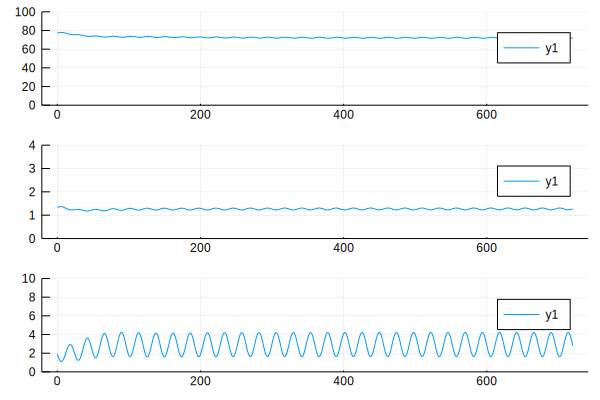

In [72]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

## Implementing dosing

Let's first try to incorporate a single T4 dose into the model at 24 hours.

In [73]:
ic, p = initialize();
tspan = (0.0, 720.0);

function condition(u, t, integrator)
    return t - 24.0
end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = ContinuousCallback(condition, affect!);

prob = ODEProblem(thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

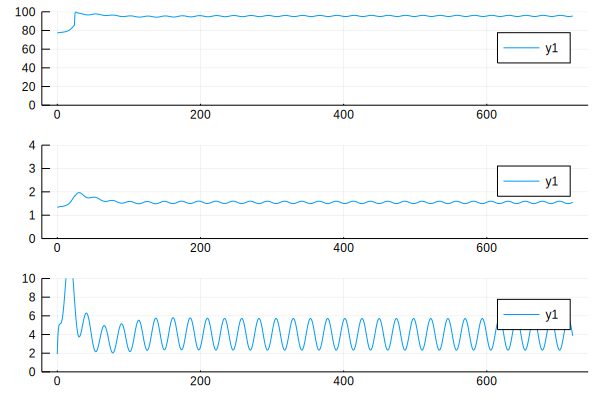

In [74]:
p1 = plot(sol.t, 777.0 * sol[1, :] / p[47], ylim=(0, 100))
p2 = plot(sol.t, 651.0 * sol[4, :] / p[47], ylim=(0, 4))
p3 = plot(sol.t, 5.6 * sol[7, :] / p[48], ylim=(0, 10))
plot(p1, p2, p3, layout=(3, 1))

This works! It's may not be straightforward to generalize this, but let's see if we can get it to do periodic dosing.

In [75]:
using DiffEqCallbacks

ArgumentError: ArgumentError: Package DiffEqCallbacks not found in current path:
- Run `import Pkg; Pkg.add("DiffEqCallbacks")` to install the DiffEqCallbacks package.


In [76]:
function output_plot(sol)
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / p[47], ylim=(0, 115), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / p[47], ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / p[48], ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    
    plot(p1, p2, p3, layout=(3, 1))
    
    ## Need to change to pick better y limits!
end
    

output_plot (generic function with 1 method)

In [77]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end

cbk = PeriodicCallback(affect!, 24.0);

prob = ODEProblem(thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

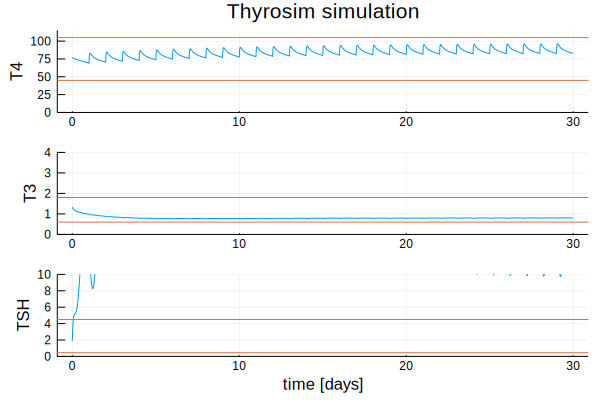

In [78]:
output_plot(sol)

This works! Now it only remains to try and get it to only start giving doses at specific places.

In [12]:
ic, p = initialize([0.0, 0.0, 0.0, 0.0]);
tspan = (0.0, 720.0);

#function condition(u, t, integrator)
#    return t - 24.0
#end
    
function affect!(t, u, integrator)
    T4_dose = 1.6 * 70.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[11] += T4_dose
    integrator.u[13] += T3_dose
end
cbk = FunctionCallingCallback(affect!;
                 funcat=[24.0, 48.0, 72.0, 240.0],
                 func_start = false)

prob = ODEProblem(thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

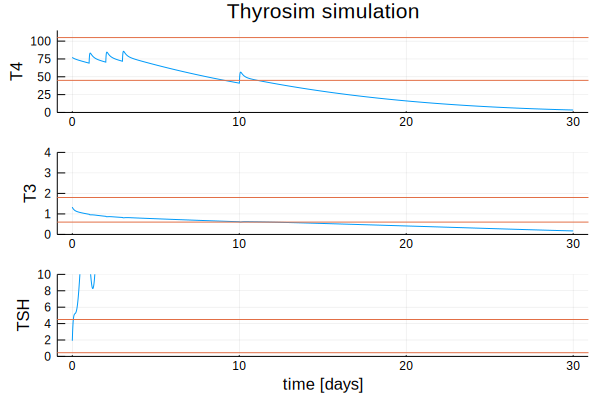

In [13]:
output_plot(sol)

In [14]:
#sol(720.0)

In [15]:
t, data400, data450, data600 = blakesley_data();

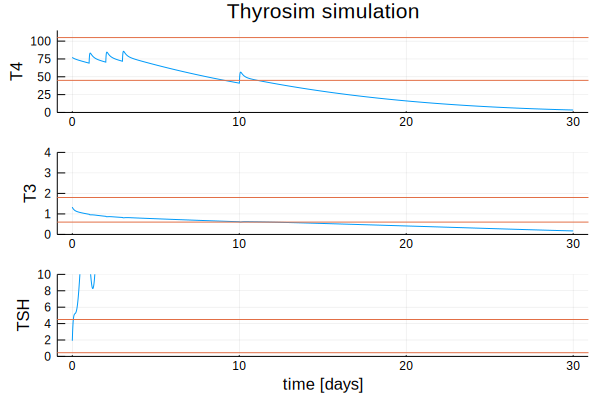

In [16]:
p = output_plot(sol)

In [17]:
ic, p = initialize();
tspan = (0.0, 120.0);

function condition(u, t, integrator)
    return t - 24.0;
end
    
function affect!(integrator)
    T4_dose = 400.0 / 777.0;
    T3_dose = 0.0;
    
    ## CHECK: Should probably be adding to pill compartments 10, 12 but do this same way as Simon's code so
    ## we can compare.
    integrator.u[10] += T4_dose;
    integrator.u[12] += T3_dose;
end

cbk = ContinuousCallback(condition, affect!);

prob = ODEProblem(thyrosim, ic, tspan, p, callback=cbk);
sol = solve(prob);

In [18]:
function plot_blakesley(sol, which="400", Vp=3.2, Vtsh=5.2)
    markersize = 2
    t_data, data400, data450, data600 = blakesley_data()
    if which == "400"
        data = data400
    elseif which == "450"
        data = data450
    else
        data = data600
    end
    
    t_data = t_data / 24.0
            
    ## Need to change to pick better y limits!
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / Vp, ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, data[:, 1], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / Vp, ylim=(0, 2), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, data[:, 2], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / Vtsh, ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, data[:, 3], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
    #return p
end

plot_blakesley (generic function with 4 methods)

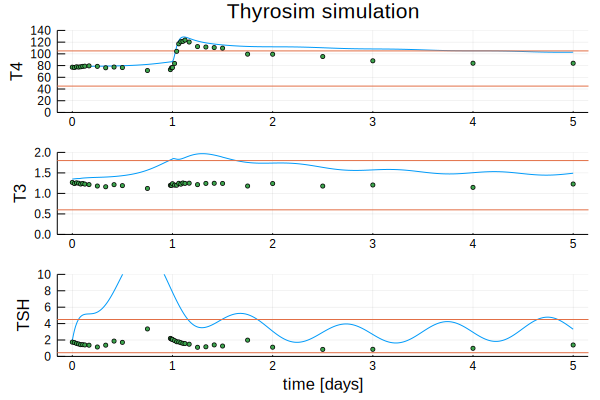

In [19]:
plot_blakesley(sol, "400")

In [20]:
function plot_jonklass_patient(sol, patient_index,
        patient_param, patient_dose, patient_t4, patient_t3, patient_tsh)
    h, w, s = patient_param[patient_index, :]
    h = h / 100.0 # Convert to meters
    s = Bool(s)
    
    Vp, Vtsh = Thyrosim.plasma_volume(h, w, s) ## CHECK FORMULA IS CORRECT.
    # Note: index means in the array, not Jonklaas's original classification.
    markersize = 2
    
    t_data = [0.0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8] / 24.0 # convert time to days.
    
    # Note: May want to change this to include Jonklaas data as input to avoid rereading all the time.
    #patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    ## Need to change to pick better y limits!
    p1 = plot(sol.t / 24.0, 777.0 * sol[1, :] / Vp, ylim=(0, 140), label="",
       ylabel="T4", title="Thyrosim simulation")
    p1 = hline!([45, 105], label= "")
    p1 = scatter!(t_data, patient_t4[patient_index, :], label="", markersize=markersize)
    
    p2 = plot(sol.t / 24.0, 651.0 * sol[4, :] / Vp, ylim=(0, 4), label="", 
       ylabel="T3")
    p2 = hline!([0.6, 1.8], label= "")
    p2 = scatter!(t_data, patient_t3[patient_index, :], label="", markersize=markersize)
    
    p3 = plot(sol.t / 24.0, 5.6 * sol[7, :] / Vtsh, ylim=(0, 10), label="",
       ylabel="TSH", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    p3 = scatter!(t_data, patient_tsh[patient_index, :], label="", markersize=markersize)
    
    plot(p1, p2, p3, layout=(3, 1))
    #return p
end

plot_jonklass_patient (generic function with 1 method)

In [66]:
function set_patient_ic!(ic, p, t4, t3, tsh;
        steady_state::Bool=false, set_tsh_lag::Bool=true)
    #println(t4, t3, tsh)
    # Set IC for observed compartments. 
    ic[1] = (p[47] * t4) / 777.0
    ic[4] = (p[47] * t3) / 651.0
    ic[7] = (p[48] * tsh) / 5.6
    
    
    if steady_state
        # Not working! Need to check.
        q4F = (p[24]+ p[25] * ic[1] + p[26] * ic[1]^2 + p[27] *ic[1]^3) * ic[4] #FT3p
        q1F = (p[7] + p[8] * ic[1] + p[9] * ic[1]^2 + p[10] * ic[1]^3) * ic[1]  #FT4p
        
        B = p[6] * q1F - p[14] * (p[3] + p[12]) - p[13]
        A = -(p[3] + p[12])
        C = p[6] * p[14] * q1F
        ic[2] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        B = p[5] * q1F - (p[4] + p[15] / p[16]) * p[18] - p[17]
        A = -(p[4] + p[15] / p[16])
        C = p[5] * p[18] * q1F
        ic[3] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        ic[5] = (p[23] * q4F + (p[13] / (p[14] + ic[2])) * ic[2]) / (p[20] + p[29])
        ic[6] = (p[22] * q4F + p[15] * (ic[3] / (p[16] + ic[3]))
            + p[17] * (ic[3] / (p[18] + ic[3]))) / p[21]
    end
    
    if set_tsh_lag
        # Probably not 100% correct since they're supposed to be lagged, but probably better than the default.
        ic[14:19] .= ic[7]
    end
    #return ic
end

set_patient_ic! (generic function with 1 method)

In [67]:
function simulate_jonklaas_patient(patient_index, patient_param, patient_dose,
        patient_t4, patient_t3, patient_tsh)
    h, w, s = patient_param[patient_index, :]
    h = h / 100.0 # Convert to meters
    s = Bool(s)
    
    t4 = patient_t4[patient_index, :]
    t3 = patient_t3[patient_index, :]
    tsh = patient_tsh[patient_index, :]
    
    dose = patient_dose[patient_index]
    # Note: Is sex == 1 male or female?
    
    
    ic, p = initialize([0.00; 0.88; 0.00; 0.88], true, h, w, s);
    ic1 = copy(ic)
    set_patient_ic!(ic, p, t4[1], t3[1], tsh[1]; steady_state=true, set_tsh_lag=true)
    print(ic)
    #ic[1], ic[4], ic[7] = (p[47] * t4[1]) / 777.0, (p[47] * t3[1]) / 651.0, (p[48] * tsh[1]) / 5.6  # Check units!
    #println(t4[1], " ", t3[1], " ", tsh[1], " ", dose)
    #println(p[47], " ", p[48])
    
    tspan = (0.0, 8.0);
    
    # Add T3 dose at time zero
    ic[13] += (dose) / 651.0 

    prob = ODEProblem(thyrosim, ic, tspan, p);
    sol = solve(prob);
    return sol
end
    

simulate_jonklaas_patient (generic function with 1 method)

[0.11998075113615524, 0.06410599064312754, 0.20030262774213892, 0.004960546100522175, 0.007634974841315307, 0.04611869401781954, 4.91057292455289, 7.05727560072869, 7.05714474742141, 0.0, 0.0, 0.0, 0.0, 4.91057292455289, 4.91057292455289, 4.91057292455289, 4.91057292455289, 4.91057292455289, 4.91057292455289]

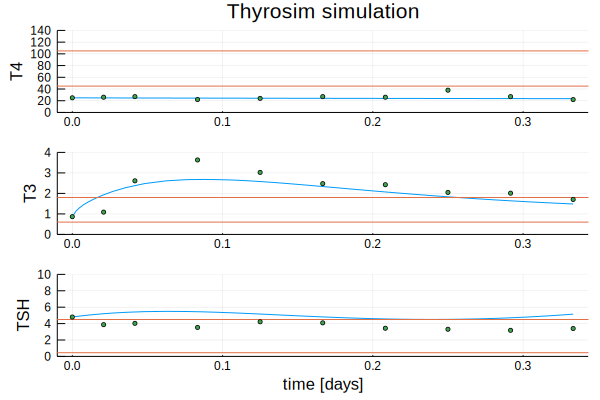

In [68]:
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
## NEED TO CHANGE ICs to STEADY STATE.
simindex = 4
sol = simulate_jonklaas_patient(simindex, patient_param, patient_dose, patient_t4, patient_t3, patient_tsh);
plot_jonklass_patient(sol, simindex, patient_param, patient_dose, patient_t4, patient_t3, patient_tsh)

In [23]:
972.0 * 3.825178161276497 / 777.0

4.78516495850805

## Google Doc with info about datasets

https://docs.google.com/document/d/12hxAIMAaObvU51dBREFXsxCdRe-ZBDgHmIB7FEi8tGc/edit?usp=sharing